# Setup

## Colab setup

Run the following cells in order (by pressing `Shift-Enter` or clicking on the "play" button at the top-left of a cell when mousing over it). When a warning pops up, choose "Run anyway".

In [ ]:
!rm -r sample_data
!git clone https://github.com/SimoneBarbaro/data_science_lab_project.git

In [ ]:
import os
os.chdir("./data_science_lab_project/data")
!wget -O TWOSIDES_medDRA.csv.gz https://polybox.ethz.ch/index.php/s/Uemf21AIiZ7ooNi/download
os.chdir("..")

While waiting for the download above to complete, open the file browser on the left by clicking on the folder icon.

**Upload the results archive `results_2020_11_27.zip` ([Polybox link](https://polybox.ethz.ch/index.php/f/2160436597)) to the `data_science_lab_project` folder** by hovering over the folder and choosing "Upload" from the three-dots menu that appears on the right. `results_2020_11_27.zip` should then be within the `data_science_lab_project` folder next to the `src` and `data` folders, which you can check by expanding the folder contents by clicking on the triangle on the left of the folder name.

Additionally, **upload the paired SPiDER data `matrix_spider_full.pkl.gz` ([Polybox link](https://polybox.ethz.ch/index.php/f/2160073828)) and `matrix_spider_names_full.pkl.gz` ([Polybox link](https://polybox.ethz.ch/index.php/f/2160073720)) into the `data` folder** (within `data_science_lab_project`) using the three-dots menu of the `data` folder. Expand the `data` folder and check that `matrix_spider_full.pkl.gz` and `matrix_spider_names_full.pkl.gz` as well as `TWOSIDES_medDRA.csv.gz` downloaded automatically above are present in it.

In [ ]:
!unzip results_*.zip

In [ ]:
!pip install -r src/requirements.txt
os.chdir("src")

Running the following cell should now list the runs that can be analyzed: each is a clustering method followed by the number of clusters and other relevant parameters.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
cwd = os.getcwd()
results_directory = "../results"
results_directory = os.path.join(cwd, results_directory)
for f in sorted(os.listdir(results_directory)):
    path = os.path.join(results_directory, f)
    if os.path.isdir(path):
        print(f)

aggl10
aggl10ave
aggl15
aggl15ave
aggl20
aggl20ave
aggl30
aggl30ave
aggl5
aggl5ave
aggl8
gmm10
gmm15
gmm20
gmm30
kmeans16
kmeans18
kmeans20
kmeans25
kmeans30


## Choose one of the clustering metod from above here

In [2]:
name_analysis = 'aggl15'

Some of the results are done on spiders, others on tiger. The name of the analysis should say which one it is. Older runs did not have this because tiger was still not available so if no dataset is specified in the run name assume it's spider. 

In [3]:
dataset = "spider"

In [4]:
# The following sets up filepath variables for use later in the notebook
result_path = os.path.join(results_directory, name_analysis)
analysis_path = os.path.join(result_path, "analysis")

# Clusters

Show the beginning of the clustering results file to check it was read correctly:

In [5]:
pth = os.path.join(result_path, 'results.csv')
clustering_results = pd.read_csv(pth)
display(clustering_results.head())
print("Number of drug pairs: {}\nNumber of clusters: {} (from {} to {})".format(clustering_results.shape[0], clustering_results["cluster"].drop_duplicates().count(), clustering_results["cluster"].min(), clustering_results["cluster"].max()))

,name1,name2,cluster
0,6-aminocaproic acid,acetaminophen,9
1,6-aminocaproic acid,albuterol,9
2,6-aminocaproic acid,aspirin,9
3,6-aminocaproic acid,bumetanide,9
4,6-aminocaproic acid,cefazolin,9


Number of drug pairs: 51686
Number of clusters: 15 (from 0 to 14)


Query for a specific drug pair provide names of both drugs in cell below:

In [6]:
name1 = 'tamoxifen'
name2 = 'bupropion'
clustering_results[(clustering_results['name1'] == name1) & (clustering_results['name2'] == name2)]

,name1,name2,cluster
27564,tamoxifen,bupropion,4


# Side effects analysis

## Choose a level of side effects

There are five levels to the MedDRA hierarchy, of which four are available here. `System Organ Classes (SOC)` are the highest level terms based on location, etiology, or purpose. `High Level Group Terms (hlgt)` which are the next highest level terms are groups of `High Level Terms (hlt)` grouped together by anatomy, pathology, physiology, etiology and function. Likewise, `High Level Terms (hlt)`s themselves are groups of `Preferred Terms (pt)`, the most specific terms, grouped together by the same criteria.

In the cell below, choose the analysis level of Meddra terms to look at for the analysis.

In [7]:
analysis_level = 'soc'

In [8]:
pth = os.path.join(analysis_path, 'scores_' + analysis_level + '_term.csv')
sideeffect_results = pd.read_csv(pth)
sideeffect_results

,cluster,soc_term,perc,tfidf_score,rank
0,0,Nervous system disorders,0.101110,0.417353,1.0
1,0,General disorders and administration site cond...,0.077206,0.318681,2.0
2,0,Gastrointestinal disorders,0.075313,0.310867,3.0
3,0,Vascular disorders,0.072227,0.298130,4.0
4,0,"Respiratory, thoracic and mediastinal disorders",0.065317,0.269610,5.0
...,...,...,...,...,...
385,14,Surgical and medical procedures,0.009520,0.039198,22.0
386,14,Social circumstances,0.006525,0.026868,23.0
387,14,Ear and labyrinth disorders,0.006041,0.024876,24.0
388,14,"Pregnancy, puerperium and perinatal conditions",0.001584,0.006523,25.0


Show the top `N` side effects per group:

In [9]:
N = 4

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sideeffect_results.groupby("cluster").head(N).set_index(["cluster", "{}_term".format(analysis_level)]))

perc  \
cluster soc_term                                                       
0       Nervous system disorders                            0.101110   
        General disorders and administration site condi...  0.077206   
        Gastrointestinal disorders                          0.075313   
        Vascular disorders                                  0.072227   
1       Nervous system disorders                            0.095917   
        Gastrointestinal disorders                          0.076871   
        Vascular disorders                                  0.071312   
        General disorders and administration site condi...  0.069954   
2       Nervous system disorders                            0.099043   
        General disorders and administration site condi...  0.076306   
        Gastrointestinal disorders                          0.075391   
        Vascular disorders                                  0.074652   
3       Nervous system disorders                            0.099643   
        General disorders and administration site condi...  0.077263   
        Gastrointestinal disorders                          0.075248   
        Vascular disorders                                  0.071251   
4       Nervous system disorders                            0.101343   
        General disorders and administration site condi...  0.077563   
        Gastrointestinal disorders                          0.074941   
        Vascular disorders                                  0.070252   
5       Nervous system disorders                            0.097846   
        Gastrointestinal disorders                          0.076763   
        Vascular disorders                                  0.071881   
        General disorders and administration site condi...  0.070823   
6       Nervous system disorders                            0.096565   
        Gastrointestinal disorders                          0.077413   
        Vascular disorders                                  0.074972   
        General disorders and administration site condi...  0.069346   
7       Nervous system disorders                            0.096327   
        Gastrointestinal disorders                          0.076796   
        Vascular disorders                                  0.071267   
        General disorders and administration site condi...  0.071020   
8       Nervous system disorders                            0.101948   
        Gastrointestinal disorders                          0.075799   
        General disorders and administration site condi...  0.075250   
        Vascular disorders                                  0.070483   
9       Nervous system disorders                            0.100182   
        General disorders and administration site condi...  0.078707   
        Gastrointestinal disorders                          0.075259   
        Vascular disorders                                  0.069292   
10      Nervous system disorders                            0.094534   
        Gastrointestinal disorders                          0.075899   
        Vascular disorders                                  0.070775   
        General disorders and administration site condi...  0.070103   
11      Nervous system disorders                            0.098200   
        General disorders and administration site condi...  0.080404   
        Gastrointestinal disorders                          0.072917   
        Vascular disorders                                  0.071177   
12      Nervous system disorders                            0.105512   
        Psychiatric disorders                               0.077114   
        General disorders and administration site condi...  0.076323   
        Gastrointestinal disorders                          0.070956   
13      Nervous system disorders                            0.098713   
        Gastrointestinal disorders                          0.077166   
        General disorders and ad

## Clusters numbers

Show cluster labels and count them:

In [10]:
sideeffect_results["cluster"].drop_duplicates().values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [11]:
num_clusters = sideeffect_results["cluster"].drop_duplicates().count()
num_clusters

15

## Choose a specific cluster to inspect

Below, one can choose which specific cluster to look at and analyze the significant side effects by changing the `cluster_no` variable.

In [12]:
cluster_no = 0

In [13]:
sideeffect_results[sideeffect_results['cluster'] == cluster_no]

,cluster,soc_term,perc,tfidf_score,rank
0,0,Nervous system disorders,0.101110,0.417353,1.0
1,0,General disorders and administration site cond...,0.077206,0.318681,2.0
2,0,Gastrointestinal disorders,0.075313,0.310867,3.0
3,0,Vascular disorders,0.072227,0.298130,4.0
4,0,"Respiratory, thoracic and mediastinal disorders",0.065317,0.269610,5.0
5,0,Psychiatric disorders,0.064818,0.267547,6.0
6,0,Investigations,0.061782,0.255017,7.0
7,0,Musculoskeletal and connective tissue disorders,0.060411,0.249358,8.0
8,0,"Injury, poisoning and procedural complications",0.057423,0.237023,9.0
9,0,Cardiac disorders,0.056352,0.232603,10.0


# Significance Analysis

The significance analysis shows which side effects are shown to be significant in each cluster using the [Grubbs test](https://en.wikipedia.org/wiki/Grubbs%27s_test#One-sided_case) at a significance level of 0.005. Below, choose a level of MedDRA hierarchy to observe the significant side effects predicted in each cluster. <!-- The `alpha` value determines the statistical significance level for which effects are significant. Currently only results for `alpha = 0.005` are computed. // alpha = 0.005  # Currently only 0.005 is available, do not change -->

## Choose a level of side effects

In [14]:
analysis_level = 'soc'

In [15]:
pth = os.path.join(analysis_path, 'significant_' + analysis_level + '_ranks_' + str(0.005) + '.csv')
statistical_results = pd.read_csv(pth)
statistical_results

,cluster,soc_term,perc,tfidf_score,rank,grubbs
0,12,Metabolism and nutrition disorders,0.046581,0.191146,11.0,3.741657
1,3,Hepatobiliary disorders,0.016947,0.070166,18.0,3.741657
2,6,Surgical and medical procedures,0.013867,0.058020,20.0,3.323470
3,11,Surgical and medical procedures,0.010142,0.042052,21.0,1.477098


Look at the significant results summary. Each row shows a drug pair, its cluster and the top `soc`, top 3 `hlgt`, top 3 `hlt` and top 3 `pt` side effects for that cluster. `NaN` means the cluster did not have a significant side effect at a given level.

In [16]:
pth = os.path.join(analysis_path, 'significant_summary_ranks_' + str(0.005) + '.csv')
summary_results = pd.read_csv(pth)
summary_results

,name1,name2,cluster,soc1,hlgt1,hlgt2,hlgt3,hlt1,hlt2,hlt3,pt1,pt2,pt3
0,6-aminocaproic acid,acetaminophen,9,NaN,NaN,NaN,NaN,Pustular conditions,Splenic marginal zone lymphomas,Auditory function diagnostic procedures,Laryngeal papilloma,Splenic marginal zone lymphoma,Acoustic stimulation tests abnormal
1,6-aminocaproic acid,albuterol,9,NaN,NaN,NaN,NaN,Pustular conditions,Splenic marginal zone lymphomas,Auditory function diagnostic procedures,Laryngeal papilloma,Splenic marginal zone lymphoma,Acoustic stimulation tests abnormal
2,6-aminocaproic acid,aspirin,9,NaN,NaN,NaN,NaN,Pustular conditions,Splenic marginal zone lymphomas,Auditory function diagnostic procedures,Laryngeal papilloma,Splenic marginal zone lymphoma,Acoustic stimulation tests abnormal
3,6-aminocaproic acid,bumetanide,9,NaN,NaN,NaN,NaN,Pustular conditions,Splenic marginal zone lymphomas,Auditory function diagnostic procedures,Laryngeal papilloma,Splenic marginal zone lymphoma,Acoustic stimulation tests abnormal
4,6-aminocaproic acid,cefazolin,9,NaN,NaN,NaN,NaN,Pustular conditions,Splenic marginal zone lymphomas,Auditory function diagnostic procedures,Laryngeal papilloma,Splenic marginal zone lymphoma,Acoustic stimulation tests abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51681,milrinone,pravastatin,3,Hepatobiliary disorders,"Placental, amniotic and cavity disorders (excl...",NaN,NaN,Ureaplasma infections,Paraendocrine neoplasms NEC,Fibrosarcomas malignant,Foetal anticonvulsant syndrome,Neonatal cholestasis,Hepatitis B DNA assay positive
51682,pravastatin,tetracycline,3,Hepatobiliary disorders,"Placental, amniotic and cavity disorders (excl...",NaN,NaN,Ureaplasma infections,Paraendocrine neoplasms NEC,Fibrosarcomas malignant,Foetal anticonvulsant syndrome,Neonatal cholestasis,Hepatitis B DNA assay positive
51683,pravastatin,trichlormethiazide,3,Hepatobiliary disorders,"Placental, amniotic and cavity disorders (excl...",NaN,NaN,Ureaplasma infections,Paraendocrine neoplasms NEC,Fibrosarcomas malignant,Foetal anticonvulsant syndrome,Neonatal cholestasis,Hepatitis B DNA assay positive
51684,streptomycin,tetracycline,3,Hepatobiliary disorders,"Placental, amniotic and cavity disorders (excl...",NaN,NaN,Ureaplasma infections,Paraendocrine neoplasms NEC,Fibrosarcomas malignant,Foetal anticonvulsant syndrome,Neonatal cholestasis,Hepatitis B DNA assay positive


Query for specific drugs

In [17]:
name1 = 'tamoxifen'
name2 = 'bupropion'
summary_results[(summary_results['name1'] == name1) & (summary_results['name2'] == name2)]

,name1,name2,cluster,soc1,hlgt1,hlgt2,hlgt3,hlt1,hlt2,hlt3,pt1,pt2,pt3
20008,tamoxifen,bupropion,4,NaN,NaN,NaN,NaN,Leptospira infections,Gliomas benign,Non-site specific cartilage disorders congenital,Granulocytes maturation arrest,Pyroglutamate increased,Urinary tract infection viral


# Target distribution for significant clusters

This block will run the Interactive Analysis for identifying the strongest targets in each cluster.

In [18]:
from experiment.interactive_analysis import InteractiveAnalyzer

This may take some time as it needs to load TWOSIDES for further analysis.

In [19]:
analyzer = InteractiveAnalyzer(dataset, result_path)

#### Choose the level, the number of clusters to consider and the number of targets per cluster to show

In [20]:
analysis_level = 'hlgt'
targets_per_cluster = 5
cluster_number = clustering_results["cluster"].drop_duplicates().count()

In [21]:
significant_clusters, important_targets = analyzer.get_important_data(analysis_level, cluster_number, targets_per_cluster)
significant_clusters

,cluster,hlgt_term,perc,tfidf_score,rank,grubbs,counts
0,12,Respiratory disorders NEC,0.028297,0.247565,3.0,3.323470,14
1,14,Respiratory disorders NEC,0.028623,0.248115,4.0,1.477098,1
2,12,Glucose metabolism disorders (incl diabetes me...,0.015396,0.134698,11.0,3.162278,14
3,12,Sleep disorders and disturbances,0.008435,0.073796,34.0,3.140010,14
4,11,Chemical injury and poisoning,0.005036,0.044148,55.0,2.822683,9
5,12,Psychiatric and behavioural symptoms NEC,0.002369,0.020725,112.0,2.975587,14
6,12,Changes in physical activity,0.002340,0.020476,113.0,2.882750,14
7,12,Schizophrenia and other psychotic disorders,0.001743,0.015246,125.0,3.208489,14
8,12,Sexual function and fertility disorders,0.001736,0.015191,126.0,2.866911,14
9,12,Manic and bipolar mood disorders and disturbances,0.001414,0.012369,142.0,2.911798,14


In [22]:
significant_clusters, important_targets = analyzer.get_important_data(analysis_level, 12, targets_per_cluster)


Returns any clusters where an important target is from the pre-defined list of rare targets. 

In [23]:
analyzer.get_rare_important_targets(analysis_level, cluster_number, targets_per_cluster)

[]

#### Choose a specific cluster to inspect from the column "cluster" above
as well as a threshold value (between 0 and 2) representing sufficient probability for a drug pair to interact with a target.

In [40]:
cluster_no = 12
threshold = 0.5

Descriptive statistics of the distribution of SPiDER predictions for important target of the chosen cluster:

In [41]:
important_targets = analyzer.get_important_targets(cluster_no, targets_per_cluster)
desc = important_targets.describe()
frac = (important_targets > threshold).sum()/(important_targets.count())
frac = frac.rename("Fraction above Threshold")
desc.append(frac)

,Serine Threonine Kinase,DNA Polymerase,Tyrosine Kinase,Sodium Channel,"Phosphodiesterase (3,5-Cyclic-Nucleotide Phosphodiesterase)"
count,971.000000,971.000000,971.000000,971.000000,971.000000
mean,1.548456,1.431176,1.415564,1.414096,1.405195
std,0.349357,0.339046,0.341652,0.420087,0.353753
min,0.970000,0.988000,0.972000,0.498000,0.942000
25%,1.329000,0.995000,0.990000,0.998000,0.997000
50%,1.475000,1.457000,1.447000,1.460000,1.439000
75%,1.903000,1.758000,1.702500,1.854500,1.708000
max,1.983000,1.992000,1.988000,1.997000,1.997000
Fraction above Threshold,1.000000,1.000000,1.000000,0.946447,1.000000


#### Choose a target to visualize from the columns above

In [42]:
target = 'Serine Threonine Kinase'

Histogram:

In [44]:
important_targets

,Serine Threonine Kinase,DNA Polymerase,Tyrosine Kinase,Sodium Channel,"Phosphodiesterase (3,5-Cyclic-Nucleotide Phosphodiesterase)"
172,1.464,1.435,1.833,1.496,0.997
1195,1.902,0.995,1.903,1.973,1.494
1333,1.890,0.988,1.897,1.967,1.494
2217,0.989,1.480,1.452,0.998,1.654
2355,0.977,1.473,1.446,0.992,1.654
...,...,...,...,...,...
379067,1.855,1.848,1.941,1.890,1.861
383437,1.488,1.936,1.479,1.487,1.902
412652,1.365,1.879,1.372,1.414,1.327
457958,1.375,1.472,1.441,1.978,0.942


Text(0.445, 59.220000000000006, 'threshold')

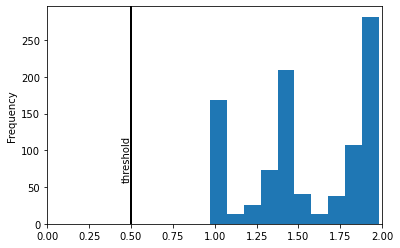

In [45]:
important_targets[target].plot.hist(xlim=[0,2])
plt.axvline(threshold, color='k', linewidth=2)
plt.text(threshold-0.055, plt.axis()[3]*0.2, 'threshold', rotation=90)